In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder


# Ignore warnings we don't care about
warnings.filterwarnings('ignore')

# Build ML model
df = pd.read_csv('./video_game_sales.csv')

list_of_genres = []
list_of_platforms = []

for index, row in df.iterrows():
    genre = row.Genre
    platform = row.Platform

    if genre not in list_of_genres:
        list_of_genres.append(genre)
    if platform not in list_of_platforms:
        list_of_platforms.append(platform)
    
list_of_genres.sort()
list_of_platforms.sort()

enc = OneHotEncoder(categories='auto', handle_unknown='ignore')
feature_arr = enc.fit_transform(df[['Genre', 'Platform']]).toarray()
feature_labels = enc.get_feature_names_out()
feature_labels = np.array(feature_labels, dtype=object).ravel()
features = pd.DataFrame(feature_arr, columns=feature_labels)

df = df.join(features).dropna()

# Break down into X inputs and Y output, drop columns we don't care about
x = df.drop(['Global_Sales', 'Platform', 'Genre', 'Publisher', 'Name', 'Rank', 'Year',
             'NA_Sales', 'JP_Sales', 'Other_Sales', 'EU_Sales'], axis=1)

x = x
y = df.Global_Sales


# 20% of the data set will go to the test size, 80% to training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Perform Linear Regression
model = LinearRegression()
model.fit(x_train, y_train)

r_sq = model.score(x, y)

# Make predictions on training set
y_lr_train_pred = model.predict(x_train)
y_lr_test_pred = model.predict(x_test)

def predict_sales(genre, platform):
    game = []
    mock_df = []
    
    for genre_name in list_of_genres:
        if genre == genre_name:
            game.append(1.0)
        else:
            game.append(0.0)
            
    for platform_name in list_of_platforms:
        if platform == platform_name:
            game.append(1.0)
        else:
            game.append(0.0)
    
    return str(round(model.predict([game])[0] * 1000000, 2))

def show_real_vs_predicted():
    plt.figure(figsize=(10, 10))
    plt.scatter(x=y_train, y=y_lr_train_pred, c="#7CAE00", alpha=0.3)
    z = np.polyfit(y_train, y_lr_train_pred, 1)
    p = np.poly1d(z)
    plt.plot(y_train, p(y_train), "#F8766D")
    plt.ylabel('Predicted Values')
    plt.xlabel('Actual Values')

    plt.show()


def get_linear_regression_metrics():
    # Build metrics for model performance
    lr_train_mse = mean_squared_error(y_train, y_lr_train_pred)
    lr_train_r2 = r2_score(y_train, y_lr_train_pred)

    lr_test_mse = mean_squared_error(y_test, y_lr_test_pred)
    lr_test_r2 = r2_score(y_test, y_lr_test_pred)

    lr_results = pd.DataFrame(['Linear regression', lr_train_mse, lr_train_r2, lr_test_mse, lr_test_r2]).transpose()
    lr_results.columns = ['Method', 'Training MSE', 'Training R2', 'Test MSE', 'Test R2']

    return lr_results


## Accuracy Metrics for Linear Regression

In [2]:
get_linear_regression_metrics()

,Method,Training MSE,Training R2,Test MSE,Test R2
0,Linear regression,1.883231,0.058692,4.210987,0.015657


## Predicted Sales vs Actual Sales

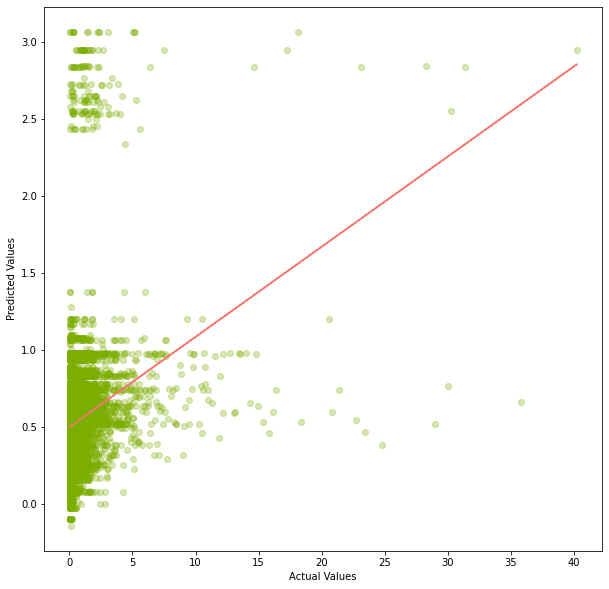

In [3]:
show_real_vs_predicted()

In [4]:
import csv

# Read CSV file for packages
with open('./video_game_sales.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')

    game_sales_by_genre = {}
    game_sales_by_platform = {}

    #Skip the header row
    next(readCSV)

    # Populate Hash Table -- O(n)
    for row in readCSV:
        game_id = row[0]
        name = row[1]
        platform = row[2]
        year = row[3]
        genre = row[4]
        publisher = row[5]
        na_sales = row[6]
        eu_sales = row[7]
        jp_sales = row[8]
        other_sales = row[9]
        global_sales = row[10]

        game = [game_id, name, platform, year, genre, publisher, na_sales, eu_sales, jp_sales, other_sales, global_sales]

        # Build dict for sales by genre
        if genre in game_sales_by_genre:
            game_sales_by_genre[genre] = round(game_sales_by_genre[genre] + float(global_sales), 2)
        else:
            game_sales_by_genre[genre] = round(float(global_sales), 2)

        # Build dict for sales by platform
        if platform in game_sales_by_platform:
            game_sales_by_platform[platform] = round(game_sales_by_platform[platform] + float(global_sales), 2)
        else:
            game_sales_by_platform[platform] = round(float(global_sales), 2)


    # Access Sales By Genre
    def get_game_sales_by_genre():
        x = []
        y = []

        byGenre = game_sales_by_genre
        for genre in byGenre:
            x.append(genre)
            y.append(byGenre[genre])
        
        return (x, y)
        

    def get_game_sales_by_platform():
        x = []
        y = []

        byPlatform = game_sales_by_platform
        for platform in byPlatform:
            x.append(platform)
            y.append(byPlatform[platform])
        
        return (x, y)


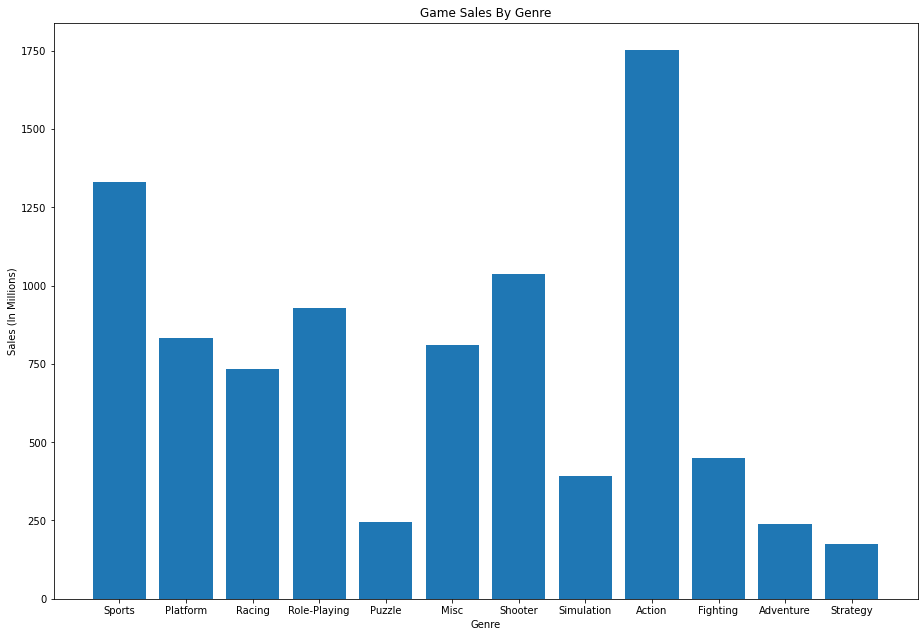

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
x,y = get_game_sales_by_genre()

ax.bar(x, y)
plt.ylabel('Sales (In Millions)')
plt.xlabel('Genre')
plt.title('Game Sales By Genre')
plt.show()

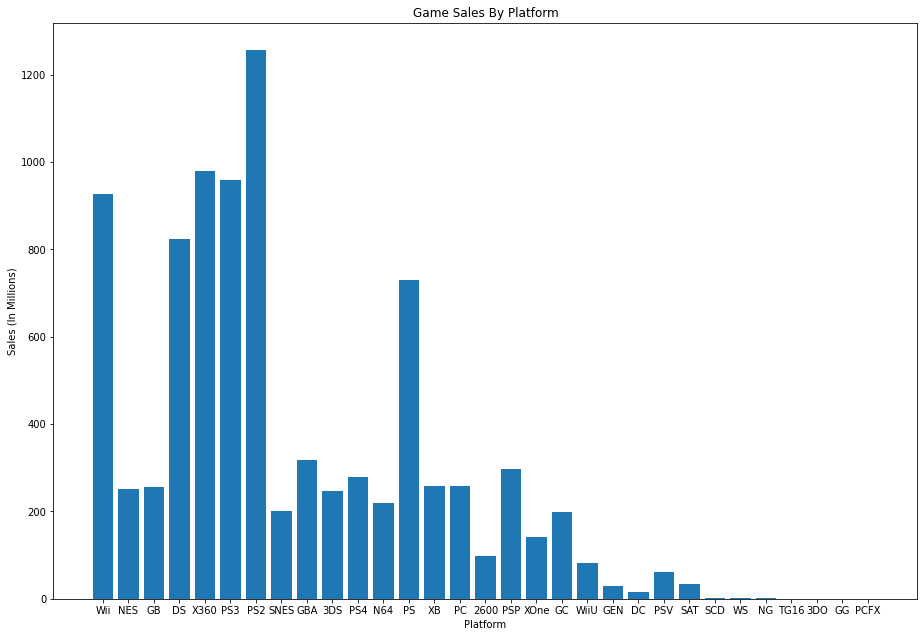

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])

x,y = get_game_sales_by_platform()

ax.bar(x, y)
plt.ylabel('Sales (In Millions)')
plt.xlabel('Platform')
plt.title('Game Sales By Platform')
plt.show()

In [7]:
import ipywidgets as widgets
from ipywidgets import *

model_predicted_sales = 0

platform_dropdown = Dropdown(
    options= list_of_platforms,
    value= list_of_platforms[0],
    description='Platform:',
    disabled=False,
)

genre_dropdown = Dropdown(
    options= list_of_genres,
    value= list_of_genres[0],
    description='Genre:',
    disabled=False,
)

predict_button = Button(
    description='Predict!',
    disabled=False,
    button_style='success'
)


def on_button_clicked(b):
    selected_genre = genre_dropdown.value
    selected_platform = platform_dropdown.value
    
    model_predicted_sales = predict_sales(selected_genre, selected_platform)
    print('Predicted Game Sales: '+ model_predicted_sales + ' units.')
    
predict_button.on_click(on_button_clicked)


## Predict Game Sales

In [8]:
display(platform_dropdown)
display(genre_dropdown)
display(predict_button)
    

Dropdown(description='Platform:', options=('2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', '…

Dropdown(description='Genre:', options=('Action', 'Adventure', 'Fighting', 'Misc', 'Platform', 'Puzzle', 'Raci…

Button(button_style='success', description='Predict!', style=ButtonStyle())